In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os
import scipy

def load_sensor_data(filename):
    df = pd.read_csv(f'../Data/raw_data/{filename}', sep=',')

    # Split the data into columns
    df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
    df.drop(columns=['Data','Index'], inplace=True)

    # Clean 
    df.dropna(inplace=True)

    # Convert the data types
    df['Cycle'] = df['Cycle'].astype(int)
    df['Position'] = df['Position'].astype(int)
    df['Reading'] = df['Reading'].astype(float)

    df['Position_Gradient'] = np.gradient(df['Position'])
    df['Direction'] = df['Position_Gradient'] > 0

    # print(df.tail())
    print(f"Data loaded from {filename}")

    return df

def plot_pr_curve(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
    plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
    plt.xlabel('Position')
    plt.ylabel('Resistance (ADC Value)')
    plt.colorbar()

def plot_data(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    df_plot2 = df_plot[(df_plot['Position'] == -400) | (df_plot['Position'] == 0)]
    plt.plot(df_plot.index, df_plot['Reading'])
    plt.scatter(df_plot2.index, df_plot2['Reading'], c=df_plot2['Position'], cmap='viridis',s=5)
    plt.title('Raw Data, 100 Cycles')
    plt.xlabel('Index')
    plt.ylabel('Resistance (ADC Value)')
    # plt.show()

print("Ready")

Ready


In [8]:
df = None
df_split = None
df_plot = None

file_name = 'data_filmed_0204_220747.csv'

# List files in the directory
files = os.listdir('../Data/raw_data')
# List files in the directory sorted by creation date
files = sorted(os.listdir('../Data/raw_data'), key=lambda x: os.path.getctime(os.path.join('../Data/raw_data', x)))

# Create a dropdown widget
file_dropdown = widgets.Dropdown(
    options=files,
    description='Select File:',
    disabled=False,
)

# Display the dropdown widget
display(file_dropdown)

df = load_sensor_data(files[-1])

# Update the file_name based on the selection
def on_file_change(change):
    global file_name, df
    file_name = change['new']

    df = load_sensor_data(file_name)

file_dropdown.observe(on_file_change, names='value')

Dropdown(description='Select File:', options=('formatted_data_0123_224049.csv', 'formatted_data_0123_224103.cs…

Data loaded from data_sa3_0212_205226.csv


Data loaded from data_sa3_0212_205226.csv
Data loaded from data_med2_0212_143649.csv
Data loaded from data_ma2_0212_152231.csv


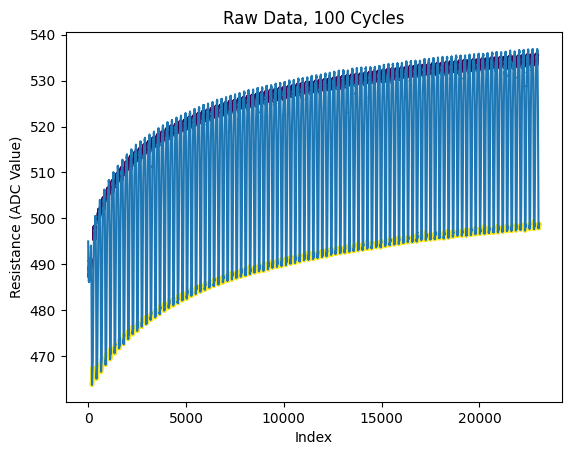

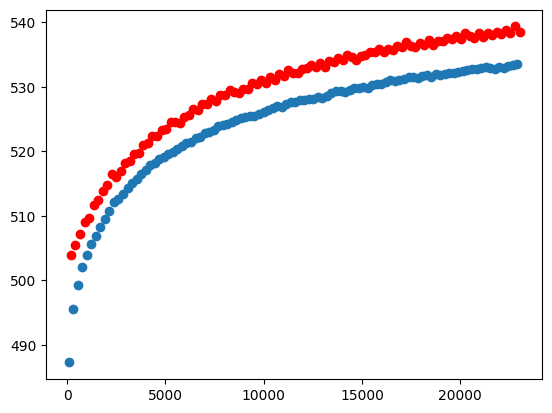

In [30]:
# plot_pr_curve(df,[0,100])
# plt.show()
plot_data(df,[0,100])
plt.show()
peaks = df[(df['Position'] == -400) & (df['Position'].shift(1) != -400)]
valleys = df[(df['Position'] == 0) & (df['Position'].shift(1) != 0)]
# plt.show()
plt.scatter(peaks.index,peaks['Reading'])
plt.scatter(valleys.index,valleys['Reading']+40,c='r')

[  9.09728623 342.61741749 389.11911259]


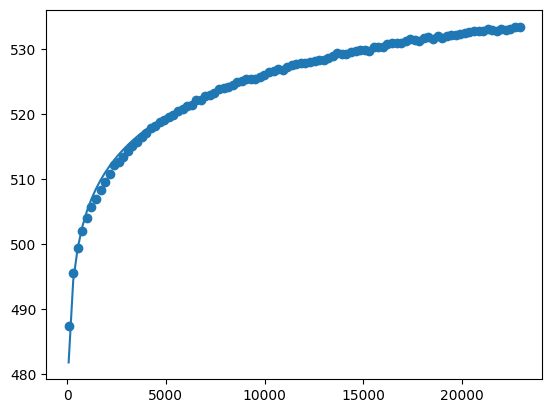

In [ ]:
import scipy.optimize


def func(x, a, b, c):
    return a * np.log(b * x) + c

popt, pcov = scipy.optimize.curve_fit(func, peaks.index, peaks['Reading'])
print(popt)

plt.scatter(peaks.index,peaks['Reading'])
plt.plot(peaks.index, func(peaks.index, *popt))